In [1]:
# Deep Belief Network (DBN) using RBMs in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
rbm_hidden_units = [256, 128]  # Two-layer DBN
epochs = 5
lr = 0.01

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# RBM Class
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_from_p(self, p):
        return torch.bernoulli(p)

    def v_to_h(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h, self.sample_from_p(p_h)

    def h_to_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return p_v, self.sample_from_p(p_v)

    def forward(self, v):
        p_h, h = self.v_to_h(v)
        p_v, v1 = self.h_to_v(h)
        return v, v1

    def contrastive_divergence(self, v):
        v0 = v
        p_h0, h0 = self.v_to_h(v0)
        p_v1, v1 = self.h_to_v(h0)
        p_h1, h1 = self.v_to_h(v1)

        self.W.grad = torch.matmul(h0.t(), v0) - torch.matmul(h1.t(), v1)
        self.v_bias.grad = torch.sum(v0 - v1, dim=0)
        self.h_bias.grad = torch.sum(h0 - h1, dim=0)

        return torch.mean(torch.sum((v0 - v1)**2, dim=1))

# Train RBM
rbms = []
input_size = 784
for hidden_units in rbm_hidden_units:
    rbm = RBM(input_size, hidden_units).to(device)
    optimizer = torch.optim.SGD(rbm.parameters(), lr=lr)

    print(f"Training RBM with {input_size} -> {hidden_units}")
    for epoch in range(epochs):
        epoch_loss = 0
        for batch, _ in train_loader:
            batch = batch.view(-1, input_size).to(device)
            optimizer.zero_grad()
            loss = rbm.contrastive_divergence(batch)
            rbm.W.grad /= batch.size(0)
            rbm.v_bias.grad /= batch.size(0)
            rbm.h_bias.grad /= batch.size(0)
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")
    rbms.append(rbm)
    input_size = hidden_units  # Output of this RBM is input to next

# DBN forward pass
class DBN(nn.Module):
    def __init__(self, rbms):
        super(DBN, self).__init__()
        self.rbms = rbms

    def forward(self, x):
        x = x.view(-1, 784)
        for rbm in self.rbms:
            x, _ = rbm.v_to_h(x)
        return x

# Visualize hidden representation
dbn = DBN(rbms).to(device)
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.to(device)
with torch.no_grad():
    embedded = dbn(images)

print("Hidden representation shape:", embedded.shape)  # e.g., [64, 128]

# You can extend this by adding a classifier on top of DBN for classification tasks.


100%|██████████| 9.91M/9.91M [00:00<00:00, 64.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 37.3MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 92.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.38MB/s]


Training RBM with 784 -> 256
Epoch 1, Loss: 666.1611
Epoch 2, Loss: 667.0072
Epoch 3, Loss: 667.0059
Epoch 4, Loss: 667.0142
Epoch 5, Loss: 667.0102
Training RBM with 256 -> 128
Epoch 1, Loss: 217.2651
Epoch 2, Loss: 217.7726
Epoch 3, Loss: 217.7730
Epoch 4, Loss: 217.7737
Epoch 5, Loss: 217.7745
Hidden representation shape: torch.Size([64, 128])


Training RBM with 784 -> 256
Epoch 1, Loss: 666.0858
Epoch 2, Loss: 666.9377
Epoch 3, Loss: 666.9350
Epoch 4, Loss: 666.9380
Epoch 5, Loss: 666.9291
Epoch 6, Loss: 666.9399
Epoch 7, Loss: 666.9415
Epoch 8, Loss: 666.9354
Epoch 9, Loss: 666.9344
Epoch 10, Loss: 666.9349
Epoch 11, Loss: 666.9351
Epoch 12, Loss: 666.9278
Epoch 13, Loss: 666.9360
Epoch 14, Loss: 666.9332
Epoch 15, Loss: 666.9301
Epoch 16, Loss: 666.9358
Epoch 17, Loss: 666.9373
Epoch 18, Loss: 666.9325
Epoch 19, Loss: 666.9362
Epoch 20, Loss: 666.9268
Epoch 21, Loss: 666.9275
Epoch 22, Loss: 666.9331
Epoch 23, Loss: 666.9334
Epoch 24, Loss: 666.9319
Epoch 25, Loss: 666.9396
Epoch 26, Loss: 666.9395
Epoch 27, Loss: 666.9346
Epoch 28, Loss: 666.9373
Epoch 29, Loss: 666.9350
Epoch 30, Loss: 666.9374


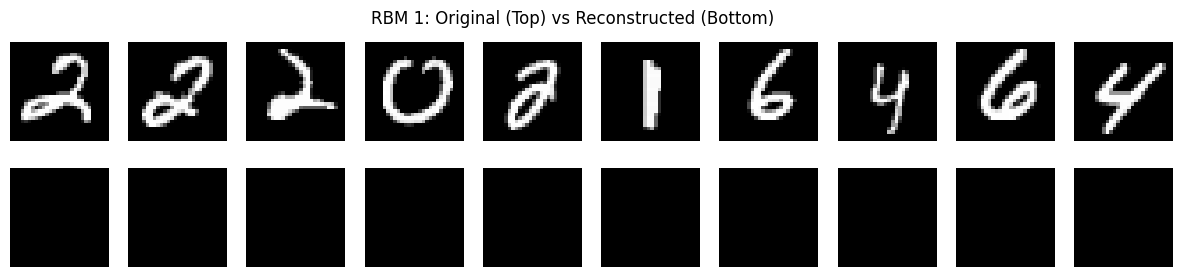

Training RBM with 256 -> 128
Epoch 1, Loss: 217.2680
Epoch 2, Loss: 217.7728
Epoch 3, Loss: 217.7734
Epoch 4, Loss: 217.7745
Epoch 5, Loss: 217.7753
Epoch 6, Loss: 217.7742
Epoch 7, Loss: 217.7734
Epoch 8, Loss: 217.7769
Epoch 9, Loss: 217.7747
Epoch 10, Loss: 217.7742
Epoch 11, Loss: 217.7729
Epoch 12, Loss: 217.7753
Epoch 13, Loss: 217.7747
Epoch 14, Loss: 217.7742
Epoch 15, Loss: 217.7760
Epoch 16, Loss: 217.7743
Epoch 17, Loss: 217.7739
Epoch 18, Loss: 217.7754
Epoch 19, Loss: 217.7752
Epoch 20, Loss: 217.7743
Epoch 21, Loss: 217.7744
Epoch 22, Loss: 217.7735
Epoch 23, Loss: 217.7741
Epoch 24, Loss: 217.7742
Epoch 25, Loss: 217.7729
Epoch 26, Loss: 217.7720
Epoch 27, Loss: 217.7740
Epoch 28, Loss: 217.7738
Epoch 29, Loss: 217.7750
Epoch 30, Loss: 217.7763


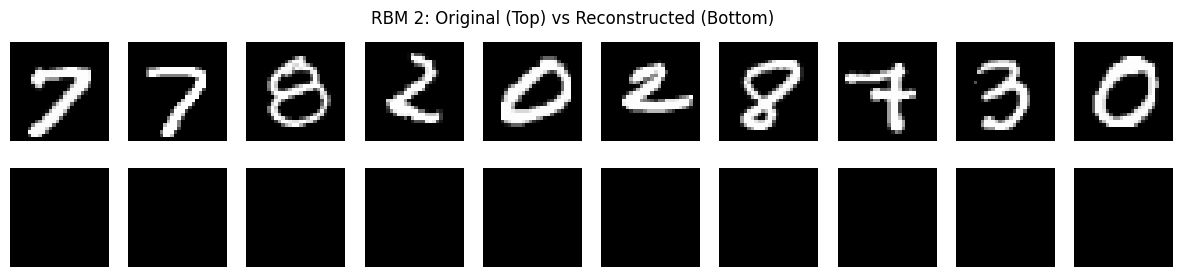

Hidden representation shape: torch.Size([64, 128])


In [3]:
# Deep Belief Network (DBN) using RBMs in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
rbm_hidden_units = [256, 128]  # Two-layer DBN
epochs = 30
lr = 0.01

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# RBM Class
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_from_p(self, p):
        return torch.bernoulli(p)

    def v_to_h(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h, self.sample_from_p(p_h)

    def h_to_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return p_v, self.sample_from_p(p_v)

    def forward(self, v):
        p_h, h = self.v_to_h(v)
        p_v, v1 = self.h_to_v(h)
        return v, v1

    def contrastive_divergence(self, v):
        v0 = v
        p_h0, h0 = self.v_to_h(v0)
        p_v1, v1 = self.h_to_v(h0)
        p_h1, h1 = self.v_to_h(v1)

        self.W.grad = torch.matmul(h0.t(), v0) - torch.matmul(h1.t(), v1)
        self.v_bias.grad = torch.sum(v0 - v1, dim=0)
        self.h_bias.grad = torch.sum(h0 - h1, dim=0)

        return torch.mean(torch.sum((v0 - v1)**2, dim=1))

# Train RBM
rbms = []
input_size = 784
for idx, hidden_units in enumerate(rbm_hidden_units):
    rbm = RBM(input_size, hidden_units).to(device)
    optimizer = torch.optim.SGD(rbm.parameters(), lr=lr)

    print(f"Training RBM with {input_size} -> {hidden_units}")
    for epoch in range(epochs):
        epoch_loss = 0
        for batch, _ in train_loader:
            batch = batch.view(-1, input_size).to(device)
            optimizer.zero_grad()
            loss = rbm.contrastive_divergence(batch)
            rbm.W.grad /= batch.size(0)
            rbm.v_bias.grad /= batch.size(0)
            rbm.h_bias.grad /= batch.size(0)
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Visualize reconstruction from RBM
    batch, _ = next(iter(train_loader))
    batch = batch.view(-1, input_size).to(device)
    with torch.no_grad():
        v, v_recon = rbm(batch)
    v = v.view(-1, 1, 28, 28).cpu()
    v_recon = v_recon.view(-1, 1, 28, 28).cpu()

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(v[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(v_recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(f"RBM {idx+1}: Original (Top) vs Reconstructed (Bottom)")
    plt.show()

    rbms.append(rbm)
    input_size = hidden_units  # Output of this RBM is input to next

# DBN forward pass
class DBN(nn.Module):
    def __init__(self, rbms):
        super(DBN, self).__init__()
        self.rbms = rbms

    def forward(self, x):
        x = x.view(-1, 784)
        for rbm in self.rbms:
            x, _ = rbm.v_to_h(x)
        return x

# Visualize hidden representation
dbn = DBN(rbms).to(device)
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.to(device)
with torch.no_grad():
    embedded = dbn(images)

print("Hidden representation shape:", embedded.shape)  # e.g., [64, 128]

# You can extend this by adding a classifier on top of DBN for classification tasks.
